# Visualization notebook

This notebook is meant for visualizing stuff and testing code. 


## Imports and functions

In [20]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
from pathlib import Path
from more_itertools import chunked
from dataclasses import dataclass
from nltk.tokenize import word_tokenize
from collections import defaultdict, Counter
from gram2vec.featurizers import GrammarVectorizer
warnings.filterwarnings("ignore", category=FutureWarning)

# PAN 2022 Summary Stats & Visualizations


In [10]:
@dataclass
class Author:
    """
    Stores author information in an easy to work with format
    
    :param author_id: unique author id
    :param fixed_texts: list of author documents with regex fixes
    :param raw_texts: list of author documents without regex fixes
    :param discourse_types: list of discourse types
    
    Note: fixed_docs, raw_docs, and discourse_types are all 1 - 1 corresponding
    """
    author_id:str
    fixed_texts:list[str]
    raw_texts:list[str]
    discourse_types:list[str]
    
    def get_token_counts(self) -> list[int]:
        return [len(word_tokenize(author_doc)) for author_doc in self.fixed_texts]
    
    def get_total_docs(self) -> int:
        return len(self.fixed_texts)
    
    def count_dicourse_type(self, dtype:str) -> int:
        return Counter(self.discourse_types)[dtype]
        
def load_json(path:str) -> dict[str, list[dict]]:
    with open(path, "r") as fin:
        data = json.load(fin)
        return data

def extract_from_dict(author_entry:dict, to_extract:str) -> list[str]:
    return [entry[to_extract] for entry in author_entry]
    
def create_author_list(preprocessed_data:dict[str, list[dict]]) -> list[Author]:
    """
    Converts the preprocessed_data.json data into a list of Author objects
    """
    authors = []
    for author_id in preprocessed_data.keys():
        author_entry = preprocessed_data[author_id]
        fixed_texts = extract_from_dict(author_entry,"fixed_text")
        raw_texts = extract_from_dict(author_entry,"raw_text")
        discourse_types = extract_from_dict(author_entry,"discourse_type")
            
        authors.append(Author(author_id, fixed_texts, raw_texts, discourse_types))
        
    return authors

def get_doc_token_stats(authors:list[Author]) -> tuple[float, float]:
    """Gets the mean and std of tokens per document"""
    all_doc_token_counts = []
    for author in authors:
        all_doc_token_counts.extend(author.get_token_counts())
    return np.mean(all_doc_token_counts), np.std(all_doc_token_counts)
    
def make_author_df(authors:list[Author]) -> pd.DataFrame:
    
    author_maps = defaultdict(list)
    for author in authors:
        author_maps["author_id"].append(author.author_id)
        author_maps["total_token_count"].append(sum(author.get_token_counts()))
        author_maps["Total docs"].append(author.get_total_docs())
        author_maps["Emails"].append(author.count_dicourse_type("email"))
        author_maps["Memos"].append(author.count_dicourse_type("memo"))
        author_maps["Text messages"].append(author.count_dicourse_type("text_message"))
        author_maps["Essays"].append(author.count_dicourse_type("essay"))
        
    return pd.DataFrame(author_maps)


In [168]:

data = load_json("data/pan22/preprocessed/preprocessed_data.json")
all_authors = create_author_list(data)

avg_tokens_per_doc, std_tokens_per_doc = get_doc_token_stats(all_authors)

df = make_author_df(all_authors)

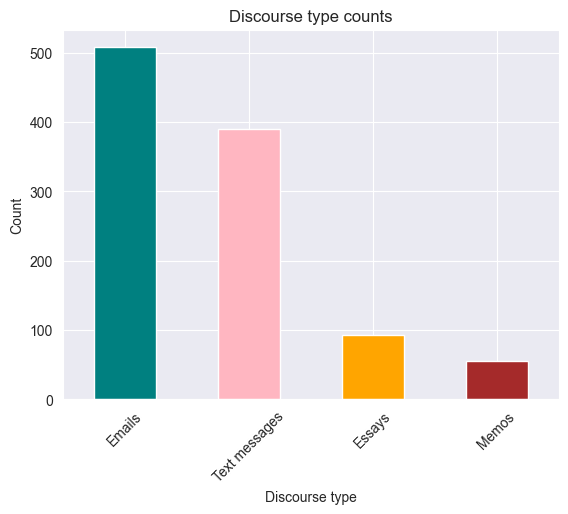

In [170]:
sns.set_style("darkgrid")

dtype_df = df[["Emails", "Text messages", "Essays", "Memos"]].sum()
dtype_df.plot.bar(color=["teal", "lightpink", "orange", "brown"])
plt.title("Discourse type counts")
plt.xlabel("Discourse type")
plt.ylabel("Count")
plt.xticks(rotation=45)

#! ADD AVG DISCOURSE TYPE TOKEN COUNT UNDER EACH BAR LABEL
plt.show()

Text(0, 0.5, '# of authors')

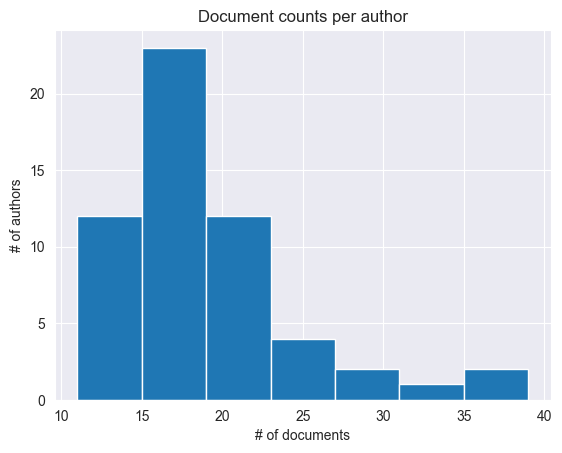

In [191]:
df["Total docs"].hist(bins=7)
plt.title("Document counts per author")
plt.xlabel("# of documents")
plt.ylabel("# of authors")


In [7]:
df = pd.read_csv("eval/results/pan_dev_bin_results.csv")

np.array(df["Accuracy"])

array([0.        , 0.31428571, 0.17142857, 0.2       , 0.2       ,
       0.2       , 0.31428571, 0.48571429])

## Dev bin visuals

Text(0.5, 1.0, 'R@1 Development scores')

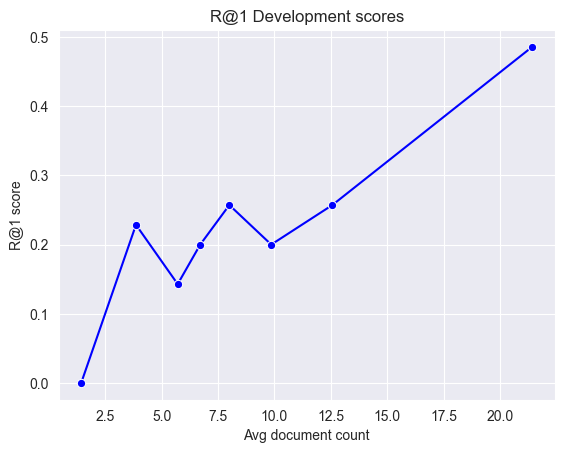

In [62]:
from data.scripts.pan_create_bins import get_train_authors_sorted_by_docfreq

def bin_authors(iterable) -> tuple[list[str], ...]:
    return tuple(chunked(iterable, 7)) 

def make_doc_avg_labels(sorted_dict):
       
       labels = []
       for bin in bin_authors(list(sorted_dict.values())):
              labels.append(round(np.mean(bin), 2))
       return labels

train_path = "eval/pan22_splits/knn/train.json"
train_authors_sorted = get_train_authors_sorted_by_docfreq(train_path)
labels = make_doc_avg_labels(train_authors_sorted)

# k = 6
all_features = np.array([0., 0.22857143, 0.14285714, 0.2, 0.25714286,0.2, 0.25714286, 0.48571429])
half_features = np.array([0.,0.31428571, 0.17142857, 0.2, 0.2 ,0.2, 0.31428571, 0.48571429])




df = pd.DataFrame({
       "Bin labels": labels,
       "Full features": all_features,
       "Half features": half_features
})

sns.set_style("darkgrid")


sns.lineplot(data=df, x="Bin labels", y="Full features",color="blue",marker="o")
plt.xlabel("Avg document count")
plt.ylabel("R@1 score")
plt.title("R@1 Development scores")



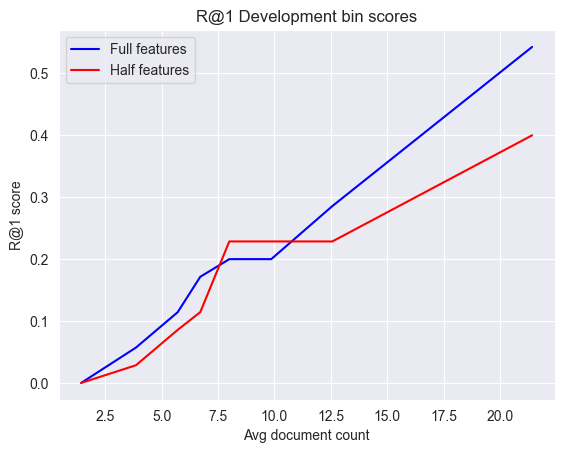

In [54]:
ALL_FEATS_ACCS = [0.0, 0.05714285714285714, 0.11428571428571428, 0.17142857142857143, 0.2, 0.2, 0.2857142857142857, 0.5428571428571428]
HALF_FEATS_ACCS = [0.0, 0.02857142857142857, 0.08571428571428572, 0.11428571428571428, 0.22857142857142856, 0.22857142857142856, 0.22857142857142856, 0.4]

old_df = pd.DataFrame(
    {"Full features": ALL_FEATS_ACCS,
     "Half features": HALF_FEATS_ACCS,
     "Bin labels":labels}
)


sns.lineplot(data=old_df, x="Bin labels", y="Full features",color="blue", label="Full features")
sns.lineplot(data=old_df, x="Bin labels", y="Half features", color="red", label="Half features")
plt.xlabel("Avg document count")
plt.ylabel("R@1 score")
plt.title("R@1 Development bin scores")
plt.legend()

plt.show()